# 1. Loading and normalizing MNIST

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
batch_size = 100

transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = list(range(10))
print(len(trainset))
log_freq = len(trainset)//batch_size
print(log_freq)
print(len(testset))

60000
600
10000


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

In [4]:
def imshow(img):
    npimg = img.numpy();print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)));print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.show()

torch.Size([100, 1, 28, 28])
(3, 392, 242)
(392, 242, 3)


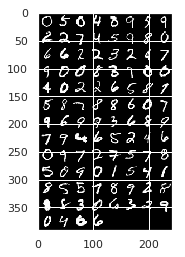

    0     5     0     4


In [5]:
# show images
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 2. Define a Net with IB architecture

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
# K is for latent dim
K = 256
num_latent = 12

class Net(nn.Module):
    def __init__(self, K=K, num_latent=num_latent):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 1024)
        self.fc2 = nn.Linear(1024,1024)
        self.enc_mean = nn.Linear(1024, K)
        self.enc_std = nn.Linear(1024, K)
        self.dec = nn.Linear(K, 10)
        self.num_latent = num_latent
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        nn.init.xavier_uniform_(self.enc_mean.weight)
        nn.init.constant_(self.enc_mean.bias, 0.0)
        nn.init.xavier_uniform_(self.enc_std.weight)
        nn.init.constant_(self.enc_std.bias, 0.0)
        nn.init.xavier_uniform_(self.dec.weight)
        nn.init.constant_(self.dec.bias, 0.0)
        
    def forward(self, x):
        x = x.view(-1, 784)
        x = 2*x - 1. # input normalize to [-1,1]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        enc_mean, enc_std = self.enc_mean(x), F.softplus(self.enc_std(x)-5)
        latent = enc_mean.unsqueeze(1) + torch.randn((tuple(enc_std.shape)[0],)\
                                        +(self.num_latent,)\
                                        + tuple(enc_std.shape)[1:]).cuda() * enc_std.unsqueeze(1)
        outputs = F.softmax(self.dec(latent),dim=2)
        output = torch.mean(outputs, dim=1)
        return outputs, output, enc_mean, enc_std
    
def update_target(target, original, update_rate):
        for target_param, param in zip(target.parameters(), original.parameters()):
            target_param.data.copy_((1.0 - update_rate) * target_param.data + update_rate*param.data)

# 3. Define a Loss function and optimizer

In [8]:
import torch.optim as optim

In [9]:
CE = nn.CrossEntropyLoss()
betas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

def calc_loss(outputs, labels, enc_mean, enc_std, beta=1e-4):
    labels = labels.view(-1,1) * torch.ones(batch_size, num_latent, dtype=torch.long).cuda()
    ce = CE(outputs.view(-1,10), labels.view(-1))
    loss = ce + beta * 0.5 * torch.mean(torch.sum(enc_mean**2 + \
                                        enc_std**2 - torch.log(enc_std**2) - 1,dim=1))
    return loss

In [10]:
def train(beta, epoch, net, net_test, optimizer, log_freq=log_freq):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, output, end_means, enc_stds = net(inputs)
        loss = calc_loss(outputs, labels, end_means, enc_stds, beta)
        loss.backward()
        optimizer.step()
        update_target(net_test, net, 0.001)

        # print statistics
        running_loss += loss.item()
        if (i+1) % log_freq == 0:    # print every 2000 mini-batches
            print('[Epoch : %d, Iter: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / log_freq))
    return running_loss / log_freq
        
def test(net_test):
    print('Start test')
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, output, end_means, enc_stds = net_test(inputs)
            _, predicted = torch.max(output, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %.2f %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

    test_score = np.mean([100 * class_correct[i] / class_total[i] for i in range(10)])
    print(test_score)
    return test_score

In [11]:
from tqdm import tqdm_notebook

epoch_num = 200
test_freq = 10
losses = list()
test_scores = list()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# SAVE
def save(beta, net, net_test):
    net_path = './model/net'+str(beta)+'.pkl'
    net_test_path = './model/net_test'+str(beta)+'.pkl'
    net = net.cpu()
    torch.save(net.state_dict(), net_path)
    net_test = net_test.cpu()
    torch.save(net_test.state_dict(), net_test_path)
    # Place it to GPU back
    net.to(device)
    net_test.to(device)
    return net, net_test
    
def load(beta, net, net_test):
    net_path = './model/net'+str(beta)+'.pkl'
    net_test_path = './model/net_test'+str(beta)+'.pkl'
    # LOAD
    net.load_state_dict(torch.load(net_path))
    net_test.load_state_dict(torch.load(net_test_path))
    # Place it to GPU
    net.to(device)
    net_test.to(device)
    return net, net_test

def main():
    for beta in betas:
        print(beta)
        net = Net()
        net_test = Net()
        if torch.cuda.device_count() > 1:
            print("Let's use",torch.cuda.device_count(),"GPUs!")
            net = nn.DataParallel(net)
            net_test = nn.DataParallel(net_test)
        net.to(device)
        net_test.to(device)
        net_test.load_state_dict(net.state_dict())
        
        optimizer = optim.Adam(net.parameters(), lr=1e-4, betas=(0.5,0.999))
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.97)

        for i in tqdm_notebook(range(epoch_num)):
            loss_avg = train(beta=beta, net=net, net_test=net_test, optimizer=optimizer, epoch=i)
            losses.append(loss_avg)
            if (i+1) % test_freq == 0:
                test_score = test(net_test)
                test_scores.append(test_score)
            if (i+1) % 2 == 0:
                scheduler.step()
                
        save(beta, net, net_test)
            
main()

0.1
Let's use 4 GPUs!


[Epoch : 1, Iter:   600] loss: 5.491
[Epoch : 2, Iter:   600] loss: 2.486
[Epoch : 3, Iter:   600] loss: 2.376
[Epoch : 4, Iter:   600] loss: 2.312
[Epoch : 5, Iter:   600] loss: 2.257
[Epoch : 6, Iter:   600] loss: 2.230
[Epoch : 7, Iter:   600] loss: 2.190
[Epoch : 8, Iter:   600] loss: 2.180
[Epoch : 9, Iter:   600] loss: 2.147
[Epoch : 10, Iter:   600] loss: 2.133
Start test
Accuracy of     0 : 98.27 %
Accuracy of     1 : 98.50 %
Accuracy of     2 : 93.12 %
Accuracy of     3 : 93.37 %
Accuracy of     4 : 95.32 %
Accuracy of     5 : 90.02 %
Accuracy of     6 : 96.24 %
Accuracy of     7 : 94.07 %
Accuracy of     8 : 91.07 %
Accuracy of     9 : 78.30 %
92.8263527023345
[Epoch : 11, Iter:   600] loss: 2.113
[Epoch : 12, Iter:   600] loss: 2.104
[Epoch : 13, Iter:   600] loss: 2.090
[Epoch : 14, Iter:   600] loss: 2.088
[Epoch : 15, Iter:   600] loss: 2.074
[Epoch : 16, Iter:   600] loss: 2.067
[Epoch : 17, Iter:   600] loss: 2.060
[Epoch : 18, Iter:   600] loss: 2.055
[Epoch : 19, Iter

[Epoch : 121, Iter:   600] loss: 1.951
[Epoch : 122, Iter:   600] loss: 1.952
[Epoch : 123, Iter:   600] loss: 1.951
[Epoch : 124, Iter:   600] loss: 1.951
[Epoch : 125, Iter:   600] loss: 1.951
[Epoch : 126, Iter:   600] loss: 1.951
[Epoch : 127, Iter:   600] loss: 1.950
[Epoch : 128, Iter:   600] loss: 1.950
[Epoch : 129, Iter:   600] loss: 1.951
[Epoch : 130, Iter:   600] loss: 1.951
Start test
Accuracy of     0 : 99.08 %
Accuracy of     1 : 98.85 %
Accuracy of     2 : 97.77 %
Accuracy of     3 : 98.02 %
Accuracy of     4 : 98.07 %
Accuracy of     5 : 97.09 %
Accuracy of     6 : 98.02 %
Accuracy of     7 : 97.57 %
Accuracy of     8 : 97.74 %
Accuracy of     9 : 96.13 %
97.83386077881373
[Epoch : 131, Iter:   600] loss: 1.950
[Epoch : 132, Iter:   600] loss: 1.951
[Epoch : 133, Iter:   600] loss: 1.950
[Epoch : 134, Iter:   600] loss: 1.950
[Epoch : 135, Iter:   600] loss: 1.951
[Epoch : 136, Iter:   600] loss: 1.950
[Epoch : 137, Iter:   600] loss: 1.950
[Epoch : 138, Iter:   600] l

[Epoch : 1, Iter:   600] loss: 2.191
[Epoch : 2, Iter:   600] loss: 1.745
[Epoch : 3, Iter:   600] loss: 1.699
[Epoch : 4, Iter:   600] loss: 1.673
[Epoch : 5, Iter:   600] loss: 1.655
[Epoch : 6, Iter:   600] loss: 1.642
[Epoch : 7, Iter:   600] loss: 1.631
[Epoch : 8, Iter:   600] loss: 1.623
[Epoch : 9, Iter:   600] loss: 1.616
[Epoch : 10, Iter:   600] loss: 1.611
Start test
Accuracy of     0 : 99.29 %
Accuracy of     1 : 99.30 %
Accuracy of     2 : 97.67 %
Accuracy of     3 : 98.12 %
Accuracy of     4 : 98.17 %
Accuracy of     5 : 98.54 %
Accuracy of     6 : 98.33 %
Accuracy of     7 : 97.08 %
Accuracy of     8 : 97.64 %
Accuracy of     9 : 96.63 %
98.07642026404763
[Epoch : 11, Iter:   600] loss: 1.605
[Epoch : 12, Iter:   600] loss: 1.601
[Epoch : 13, Iter:   600] loss: 1.598
[Epoch : 14, Iter:   600] loss: 1.594
[Epoch : 15, Iter:   600] loss: 1.591
[Epoch : 16, Iter:   600] loss: 1.589
[Epoch : 17, Iter:   600] loss: 1.586
[Epoch : 18, Iter:   600] loss: 1.585
[Epoch : 19, Ite

[Epoch : 121, Iter:   600] loss: 1.553
[Epoch : 122, Iter:   600] loss: 1.553
[Epoch : 123, Iter:   600] loss: 1.553
[Epoch : 124, Iter:   600] loss: 1.553
[Epoch : 125, Iter:   600] loss: 1.553
[Epoch : 126, Iter:   600] loss: 1.553
[Epoch : 127, Iter:   600] loss: 1.553
[Epoch : 128, Iter:   600] loss: 1.553
[Epoch : 129, Iter:   600] loss: 1.553
[Epoch : 130, Iter:   600] loss: 1.553
Start test
Accuracy of     0 : 99.39 %
Accuracy of     1 : 99.38 %
Accuracy of     2 : 98.16 %
Accuracy of     3 : 98.61 %
Accuracy of     4 : 98.68 %
Accuracy of     5 : 98.43 %
Accuracy of     6 : 98.96 %
Accuracy of     7 : 98.15 %
Accuracy of     8 : 98.05 %
Accuracy of     9 : 98.02 %
98.58254858775373
[Epoch : 131, Iter:   600] loss: 1.553
[Epoch : 132, Iter:   600] loss: 1.553
[Epoch : 133, Iter:   600] loss: 1.553
[Epoch : 134, Iter:   600] loss: 1.553
[Epoch : 135, Iter:   600] loss: 1.553
[Epoch : 136, Iter:   600] loss: 1.553
[Epoch : 137, Iter:   600] loss: 1.552
[Epoch : 138, Iter:   600] l

[Epoch : 1, Iter:   600] loss: 1.717
[Epoch : 2, Iter:   600] loss: 1.575
[Epoch : 3, Iter:   600] loss: 1.550
[Epoch : 4, Iter:   600] loss: 1.536
[Epoch : 5, Iter:   600] loss: 1.526
[Epoch : 6, Iter:   600] loss: 1.519
[Epoch : 7, Iter:   600] loss: 1.513
[Epoch : 8, Iter:   600] loss: 1.509
[Epoch : 9, Iter:   600] loss: 1.505
[Epoch : 10, Iter:   600] loss: 1.502
Start test
Accuracy of     0 : 99.18 %
Accuracy of     1 : 99.03 %
Accuracy of     2 : 97.87 %
Accuracy of     3 : 98.51 %
Accuracy of     4 : 98.47 %
Accuracy of     5 : 98.99 %
Accuracy of     6 : 98.33 %
Accuracy of     7 : 97.86 %
Accuracy of     8 : 98.36 %
Accuracy of     9 : 97.42 %
98.40313723424049
[Epoch : 11, Iter:   600] loss: 1.499
[Epoch : 12, Iter:   600] loss: 1.497
[Epoch : 13, Iter:   600] loss: 1.494
[Epoch : 14, Iter:   600] loss: 1.493
[Epoch : 15, Iter:   600] loss: 1.491
[Epoch : 16, Iter:   600] loss: 1.490
[Epoch : 17, Iter:   600] loss: 1.488
[Epoch : 18, Iter:   600] loss: 1.488
[Epoch : 19, Ite

[Epoch : 121, Iter:   600] loss: 1.475
[Epoch : 122, Iter:   600] loss: 1.475
[Epoch : 123, Iter:   600] loss: 1.475
[Epoch : 124, Iter:   600] loss: 1.475
[Epoch : 125, Iter:   600] loss: 1.475
[Epoch : 126, Iter:   600] loss: 1.475
[Epoch : 127, Iter:   600] loss: 1.475
[Epoch : 128, Iter:   600] loss: 1.475
[Epoch : 129, Iter:   600] loss: 1.475
[Epoch : 130, Iter:   600] loss: 1.475
Start test
Accuracy of     0 : 99.29 %
Accuracy of     1 : 99.30 %
Accuracy of     2 : 99.03 %
Accuracy of     3 : 98.32 %
Accuracy of     4 : 98.57 %
Accuracy of     5 : 98.21 %
Accuracy of     6 : 98.43 %
Accuracy of     7 : 98.74 %
Accuracy of     8 : 98.05 %
Accuracy of     9 : 97.52 %
98.54505511948364
[Epoch : 131, Iter:   600] loss: 1.475
[Epoch : 132, Iter:   600] loss: 1.475
[Epoch : 133, Iter:   600] loss: 1.475
[Epoch : 134, Iter:   600] loss: 1.475
[Epoch : 135, Iter:   600] loss: 1.475
[Epoch : 136, Iter:   600] loss: 1.475
[Epoch : 137, Iter:   600] loss: 1.475
[Epoch : 138, Iter:   600] l

[Epoch : 1, Iter:   600] loss: 1.621
[Epoch : 2, Iter:   600] loss: 1.534
[Epoch : 3, Iter:   600] loss: 1.516
[Epoch : 4, Iter:   600] loss: 1.505
[Epoch : 5, Iter:   600] loss: 1.498
[Epoch : 6, Iter:   600] loss: 1.493
[Epoch : 7, Iter:   600] loss: 1.489
[Epoch : 8, Iter:   600] loss: 1.486
[Epoch : 9, Iter:   600] loss: 1.484
[Epoch : 10, Iter:   600] loss: 1.482
Start test
Accuracy of     0 : 99.29 %
Accuracy of     1 : 99.12 %
Accuracy of     2 : 98.26 %
Accuracy of     3 : 98.22 %
Accuracy of     4 : 98.47 %
Accuracy of     5 : 98.65 %
Accuracy of     6 : 98.54 %
Accuracy of     7 : 97.96 %
Accuracy of     8 : 98.25 %
Accuracy of     9 : 97.52 %
98.42782463669506
[Epoch : 11, Iter:   600] loss: 1.479
[Epoch : 12, Iter:   600] loss: 1.478
[Epoch : 13, Iter:   600] loss: 1.477
[Epoch : 14, Iter:   600] loss: 1.475
[Epoch : 15, Iter:   600] loss: 1.474
[Epoch : 16, Iter:   600] loss: 1.473
[Epoch : 17, Iter:   600] loss: 1.472
[Epoch : 18, Iter:   600] loss: 1.472
[Epoch : 19, Ite

[Epoch : 121, Iter:   600] loss: 1.464
[Epoch : 122, Iter:   600] loss: 1.464
[Epoch : 123, Iter:   600] loss: 1.464
[Epoch : 124, Iter:   600] loss: 1.464
[Epoch : 125, Iter:   600] loss: 1.464
[Epoch : 126, Iter:   600] loss: 1.464
[Epoch : 127, Iter:   600] loss: 1.464
[Epoch : 128, Iter:   600] loss: 1.464
[Epoch : 129, Iter:   600] loss: 1.464
[Epoch : 130, Iter:   600] loss: 1.464
Start test
Accuracy of     0 : 99.39 %
Accuracy of     1 : 99.47 %
Accuracy of     2 : 98.93 %
Accuracy of     3 : 98.81 %
Accuracy of     4 : 98.47 %
Accuracy of     5 : 98.88 %
Accuracy of     6 : 98.96 %
Accuracy of     7 : 98.35 %
Accuracy of     8 : 98.36 %
Accuracy of     9 : 98.12 %
98.77332384808184
[Epoch : 131, Iter:   600] loss: 1.464
[Epoch : 132, Iter:   600] loss: 1.464
[Epoch : 133, Iter:   600] loss: 1.464
[Epoch : 134, Iter:   600] loss: 1.464
[Epoch : 135, Iter:   600] loss: 1.464
[Epoch : 136, Iter:   600] loss: 1.464
[Epoch : 137, Iter:   600] loss: 1.464
[Epoch : 138, Iter:   600] l

[Epoch : 1, Iter:   600] loss: 1.607
[Epoch : 2, Iter:   600] loss: 1.523
[Epoch : 3, Iter:   600] loss: 1.507
[Epoch : 4, Iter:   600] loss: 1.498
[Epoch : 5, Iter:   600] loss: 1.491
[Epoch : 6, Iter:   600] loss: 1.488
[Epoch : 7, Iter:   600] loss: 1.485
[Epoch : 8, Iter:   600] loss: 1.482
[Epoch : 9, Iter:   600] loss: 1.479
[Epoch : 10, Iter:   600] loss: 1.478
Start test
Accuracy of     0 : 99.18 %
Accuracy of     1 : 99.38 %
Accuracy of     2 : 98.06 %
Accuracy of     3 : 98.22 %
Accuracy of     4 : 98.37 %
Accuracy of     5 : 98.54 %
Accuracy of     6 : 98.33 %
Accuracy of     7 : 97.37 %
Accuracy of     8 : 98.15 %
Accuracy of     9 : 97.13 %
98.27412562941296
[Epoch : 11, Iter:   600] loss: 1.476
[Epoch : 12, Iter:   600] loss: 1.475
[Epoch : 13, Iter:   600] loss: 1.474
[Epoch : 14, Iter:   600] loss: 1.473
[Epoch : 15, Iter:   600] loss: 1.472
[Epoch : 16, Iter:   600] loss: 1.472
[Epoch : 17, Iter:   600] loss: 1.470
[Epoch : 18, Iter:   600] loss: 1.470
[Epoch : 19, Ite

[Epoch : 121, Iter:   600] loss: 1.462
[Epoch : 122, Iter:   600] loss: 1.462
[Epoch : 123, Iter:   600] loss: 1.462
[Epoch : 124, Iter:   600] loss: 1.462
[Epoch : 125, Iter:   600] loss: 1.462
[Epoch : 126, Iter:   600] loss: 1.462
[Epoch : 127, Iter:   600] loss: 1.462
[Epoch : 128, Iter:   600] loss: 1.462
[Epoch : 129, Iter:   600] loss: 1.462
[Epoch : 130, Iter:   600] loss: 1.462
Start test
Accuracy of     0 : 99.49 %
Accuracy of     1 : 99.56 %
Accuracy of     2 : 98.93 %
Accuracy of     3 : 98.51 %
Accuracy of     4 : 98.57 %
Accuracy of     5 : 98.54 %
Accuracy of     6 : 98.64 %
Accuracy of     7 : 98.54 %
Accuracy of     8 : 98.67 %
Accuracy of     9 : 97.62 %
98.70857336481308
[Epoch : 131, Iter:   600] loss: 1.462
[Epoch : 132, Iter:   600] loss: 1.462
[Epoch : 133, Iter:   600] loss: 1.462
[Epoch : 134, Iter:   600] loss: 1.462
[Epoch : 135, Iter:   600] loss: 1.462
[Epoch : 136, Iter:   600] loss: 1.462
[Epoch : 137, Iter:   600] loss: 1.462
[Epoch : 138, Iter:   600] l

[Epoch : 1, Iter:   600] loss: 1.604
[Epoch : 2, Iter:   600] loss: 1.520
[Epoch : 3, Iter:   600] loss: 1.505
[Epoch : 4, Iter:   600] loss: 1.496
[Epoch : 5, Iter:   600] loss: 1.490
[Epoch : 6, Iter:   600] loss: 1.486
[Epoch : 7, Iter:   600] loss: 1.484
[Epoch : 8, Iter:   600] loss: 1.481
[Epoch : 9, Iter:   600] loss: 1.479
[Epoch : 10, Iter:   600] loss: 1.477
Start test
Accuracy of     0 : 99.18 %
Accuracy of     1 : 99.30 %
Accuracy of     2 : 97.87 %
Accuracy of     3 : 98.32 %
Accuracy of     4 : 98.17 %
Accuracy of     5 : 97.76 %
Accuracy of     6 : 98.23 %
Accuracy of     7 : 97.67 %
Accuracy of     8 : 97.54 %
Accuracy of     9 : 97.22 %
98.12404789284345
[Epoch : 11, Iter:   600] loss: 1.476
[Epoch : 12, Iter:   600] loss: 1.475
[Epoch : 13, Iter:   600] loss: 1.473
[Epoch : 14, Iter:   600] loss: 1.472
[Epoch : 15, Iter:   600] loss: 1.472
[Epoch : 16, Iter:   600] loss: 1.472
[Epoch : 17, Iter:   600] loss: 1.470
[Epoch : 18, Iter:   600] loss: 1.471
[Epoch : 19, Ite

[Epoch : 121, Iter:   600] loss: 1.462
[Epoch : 122, Iter:   600] loss: 1.462
[Epoch : 123, Iter:   600] loss: 1.462
[Epoch : 124, Iter:   600] loss: 1.462
[Epoch : 125, Iter:   600] loss: 1.462
[Epoch : 126, Iter:   600] loss: 1.462
[Epoch : 127, Iter:   600] loss: 1.462
[Epoch : 128, Iter:   600] loss: 1.462
[Epoch : 129, Iter:   600] loss: 1.462
[Epoch : 130, Iter:   600] loss: 1.462
Start test
Accuracy of     0 : 99.49 %
Accuracy of     1 : 99.65 %
Accuracy of     2 : 98.64 %
Accuracy of     3 : 98.51 %
Accuracy of     4 : 98.57 %
Accuracy of     5 : 98.32 %
Accuracy of     6 : 99.16 %
Accuracy of     7 : 98.35 %
Accuracy of     8 : 98.67 %
Accuracy of     9 : 97.92 %
98.72836186760739
[Epoch : 131, Iter:   600] loss: 1.462
[Epoch : 132, Iter:   600] loss: 1.462
[Epoch : 133, Iter:   600] loss: 1.462
[Epoch : 134, Iter:   600] loss: 1.462
[Epoch : 135, Iter:   600] loss: 1.462
[Epoch : 136, Iter:   600] loss: 1.462
[Epoch : 137, Iter:   600] loss: 1.462
[Epoch : 138, Iter:   600] l

# 5. Test for FSGM attack

In [12]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

In [13]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [14]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in tqdm_notebook(test_loader):

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        outputs, output, end_means, enc_stds = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        outputs, output, end_means, enc_stds= model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [30]:
examples = []
fin_acc = []

net = Net()
net_test = Net()
if torch.cuda.device_count() > 1:
    print("Let's use",torch.cuda.device_count(),"GPUs!")
    net = nn.DataParallel(net)
    net_test = nn.DataParallel(net_test)
# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(testset,batch_size=1, shuffle=True)

# Run test for each epsilon
for beta in betas:
    print(beta)
    accuracies = []
    net, net_test = load(beta, net, net_test)
    for eps in tqdm_notebook(epsilons):
        acc, ex = test(net_test, device, test_loader, eps)
        accuracies.append(acc)
        examples.append(ex)
    fin_acc.append(accuracies)

Let's use 4 GPUs!
0.1


Epsilon: 0	Test Accuracy = 9720 / 10000 = 0.972


Epsilon: 0.05	Test Accuracy = 6775 / 10000 = 0.6775


Epsilon: 0.1	Test Accuracy = 1882 / 10000 = 0.1882


Epsilon: 0.15	Test Accuracy = 613 / 10000 = 0.0613


Epsilon: 0.2	Test Accuracy = 295 / 10000 = 0.0295


Epsilon: 0.25	Test Accuracy = 254 / 10000 = 0.0254


Epsilon: 0.3	Test Accuracy = 226 / 10000 = 0.0226
0.01


Epsilon: 0	Test Accuracy = 9849 / 10000 = 0.9849


Epsilon: 0.05	Test Accuracy = 8905 / 10000 = 0.8905


Epsilon: 0.1	Test Accuracy = 7650 / 10000 = 0.765


Epsilon: 0.15	Test Accuracy = 5761 / 10000 = 0.5761


Epsilon: 0.2	Test Accuracy = 4367 / 10000 = 0.4367


Epsilon: 0.25	Test Accuracy = 3332 / 10000 = 0.3332


Epsilon: 0.3	Test Accuracy = 2598 / 10000 = 0.2598
0.001


Epsilon: 0	Test Accuracy = 9844 / 10000 = 0.9844


Epsilon: 0.05	Test Accuracy = 8914 / 10000 = 0.8914


Epsilon: 0.1	Test Accuracy = 7491 / 10000 = 0.7491


Epsilon: 0.15	Test Accuracy = 5606 / 10000 = 0.5606


Epsilon: 0.2	Test Accuracy = 4007 / 10000 = 0.4007


Epsilon: 0.25	Test Accuracy = 2923 / 10000 = 0.2923


Epsilon: 0.3	Test Accuracy = 2102 / 10000 = 0.2102
0.0001


Epsilon: 0	Test Accuracy = 9857 / 10000 = 0.9857


Epsilon: 0.05	Test Accuracy = 8923 / 10000 = 0.8923


Epsilon: 0.1	Test Accuracy = 6772 / 10000 = 0.6772


Epsilon: 0.15	Test Accuracy = 3780 / 10000 = 0.378


Epsilon: 0.2	Test Accuracy = 1500 / 10000 = 0.15


Epsilon: 0.25	Test Accuracy = 550 / 10000 = 0.055


Epsilon: 0.3	Test Accuracy = 195 / 10000 = 0.0195
1e-05


Epsilon: 0	Test Accuracy = 9864 / 10000 = 0.9864


Epsilon: 0.05	Test Accuracy = 8880 / 10000 = 0.888


Epsilon: 0.1	Test Accuracy = 5905 / 10000 = 0.5905


Epsilon: 0.15	Test Accuracy = 2521 / 10000 = 0.2521


Epsilon: 0.2	Test Accuracy = 856 / 10000 = 0.0856


Epsilon: 0.25	Test Accuracy = 365 / 10000 = 0.0365


Epsilon: 0.3	Test Accuracy = 251 / 10000 = 0.0251
1e-06


Epsilon: 0	Test Accuracy = 9869 / 10000 = 0.9869


Epsilon: 0.05	Test Accuracy = 8712 / 10000 = 0.8712


Epsilon: 0.1	Test Accuracy = 5028 / 10000 = 0.5028


Epsilon: 0.15	Test Accuracy = 2238 / 10000 = 0.2238


Epsilon: 0.2	Test Accuracy = 1367 / 10000 = 0.1367


Epsilon: 0.25	Test Accuracy = 1047 / 10000 = 0.1047


Epsilon: 0.3	Test Accuracy = 899 / 10000 = 0.0899


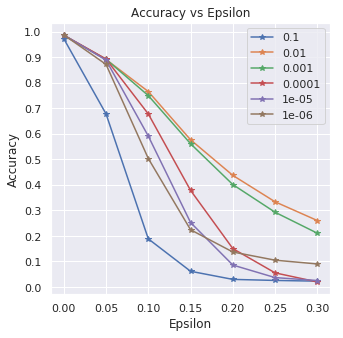

In [32]:
plt.figure(figsize=(5,5))
for i, accuracies in enumerate(fin_acc):
    plt.plot(epsilons, accuracies, "*-",label=str(betas[i]))
plt.legend()
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

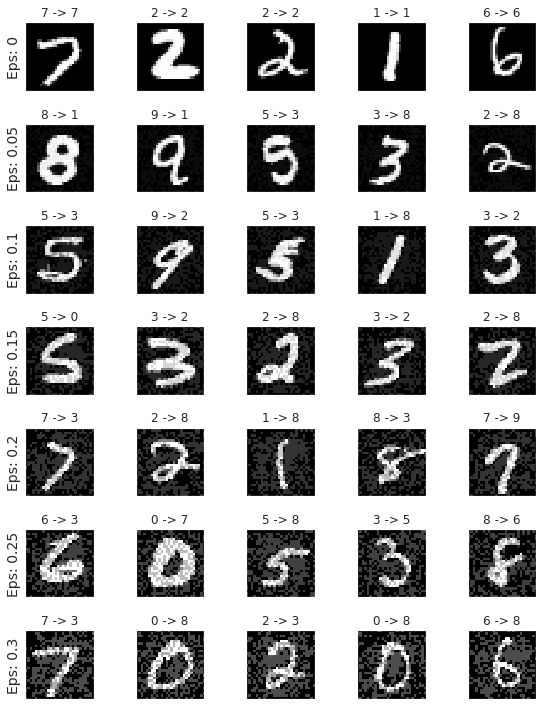

In [33]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()